# ∿ The Xylo™ IMU preprocessing interface
Xylo™ IMU contains a set of preprocessing blocks designed for encoding IMU data as events for inference using the SNN core on Xylo.
This notebook explains the design and operating principles of the IMU interface, and shows how to use the IMU IF simulation.

In [1]:
# - Imports and configuration
import numpy as np

# - Plotting and config
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.6, 3.6]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 12

try:
    from rich import print
except:
    pass

from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

from rockpool.timeseries import TSEvent

## Block diagram of IMU interface

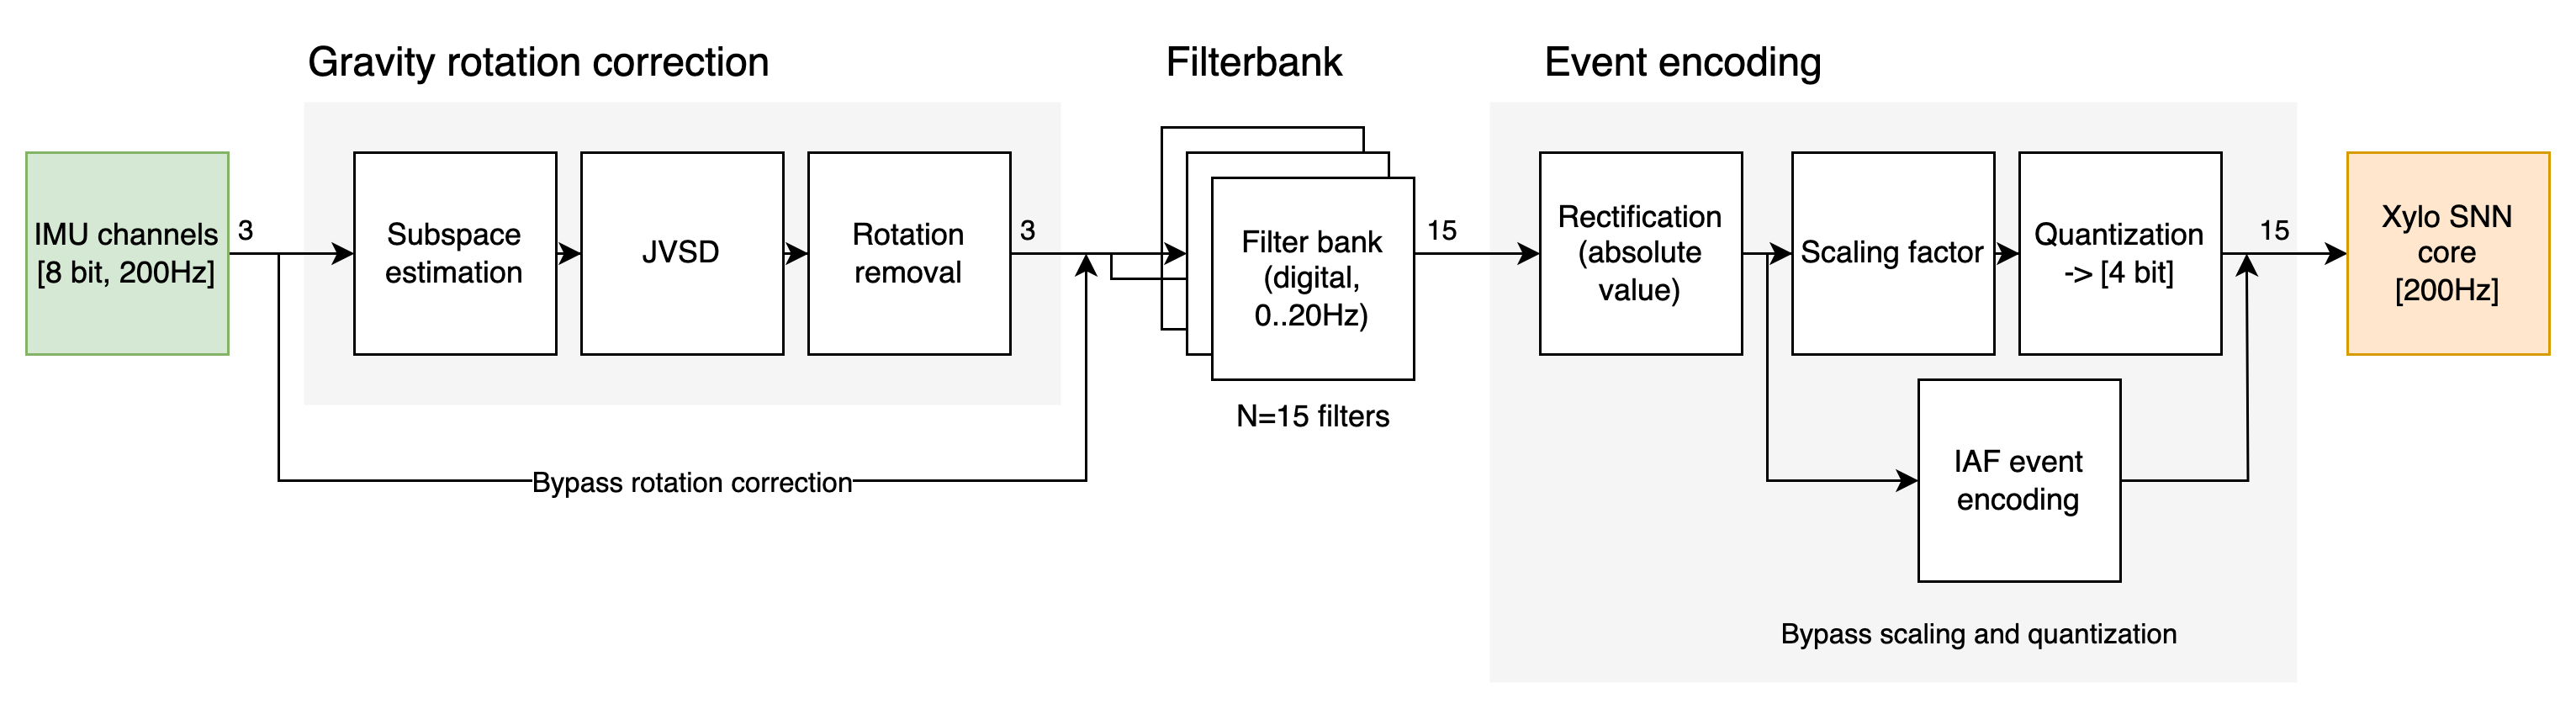

In [2]:
Image('IMU-IF-block-level.png')

**Raw IMU data** is obtained at 200 Hz from the IMU sensor, providing quantized three-channel (x, y, z) samples.

Depending on the applicaiton use-case, an IMU sensor might have an arbitrary or changing orientation in the real world.
The IMU interface contains a set of algorithms for **estimating and correcting for sensor orientation**, such that the gravitity vector is always aligned with the -Z axis. This rotation correction module can be bypassed.

The IMU data is analysed by a **tunable bank of bandpass filters**, which can separate the data frequencies with central frequencies between 0..20Hz.
Up to five filters can be used for each (x, y, z) channel of the IMU data.

Two alternative strategies are available for event encoding.
The first **quantizes and scales the filtered data** to a maximum of 15 events per time-step per channel.
The second uses a **digital integrate-and-fire neuron** to encode events.

In [3]:
# - Import Rockpool modules
from rockpool.devices.xylo.imu.preprocessing import (
    Quantizer,
    IMUIFSim
)
from samna.xyloImu.configuration import InputInterfaceConfig

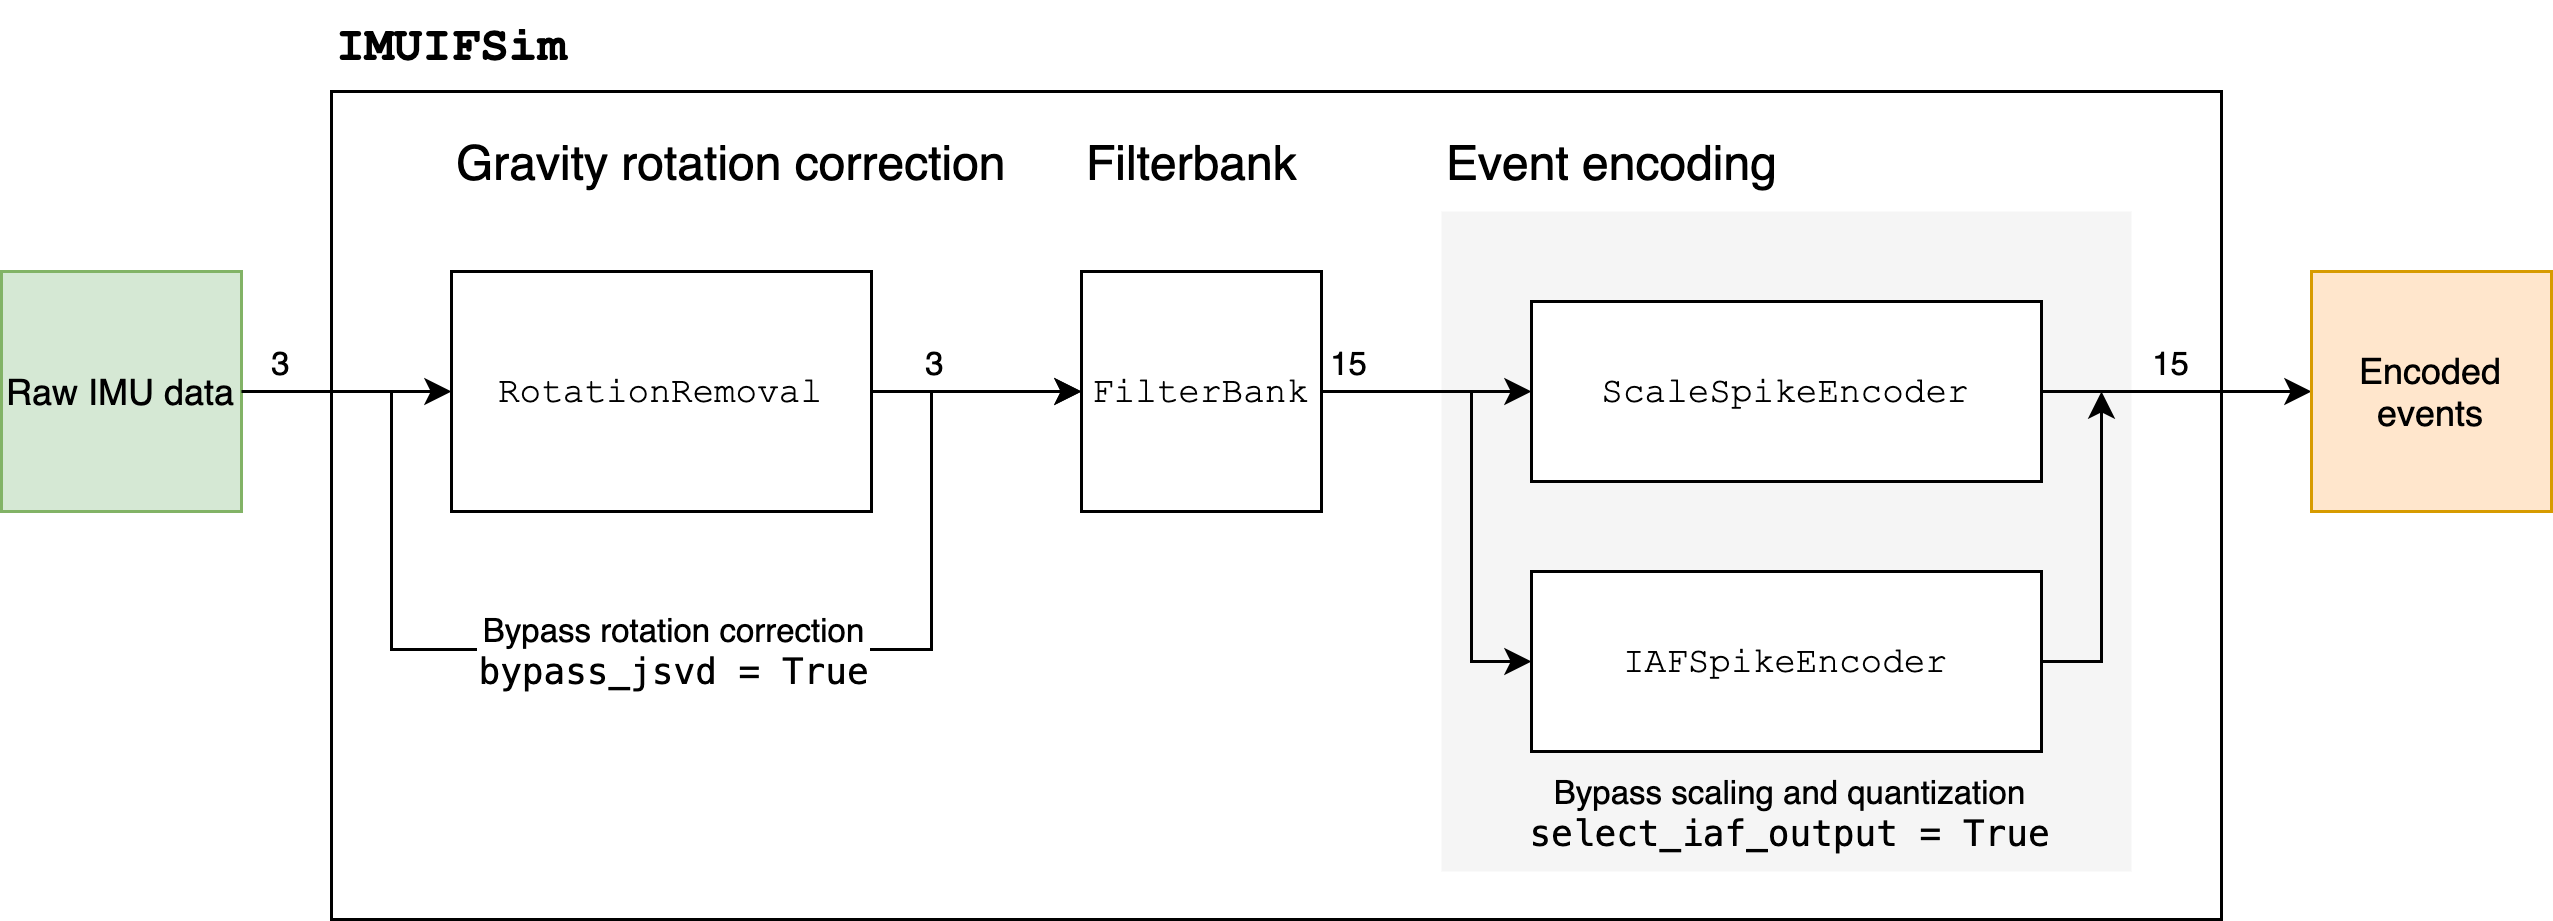

In [4]:
Image('imu-ifsim-module.png')

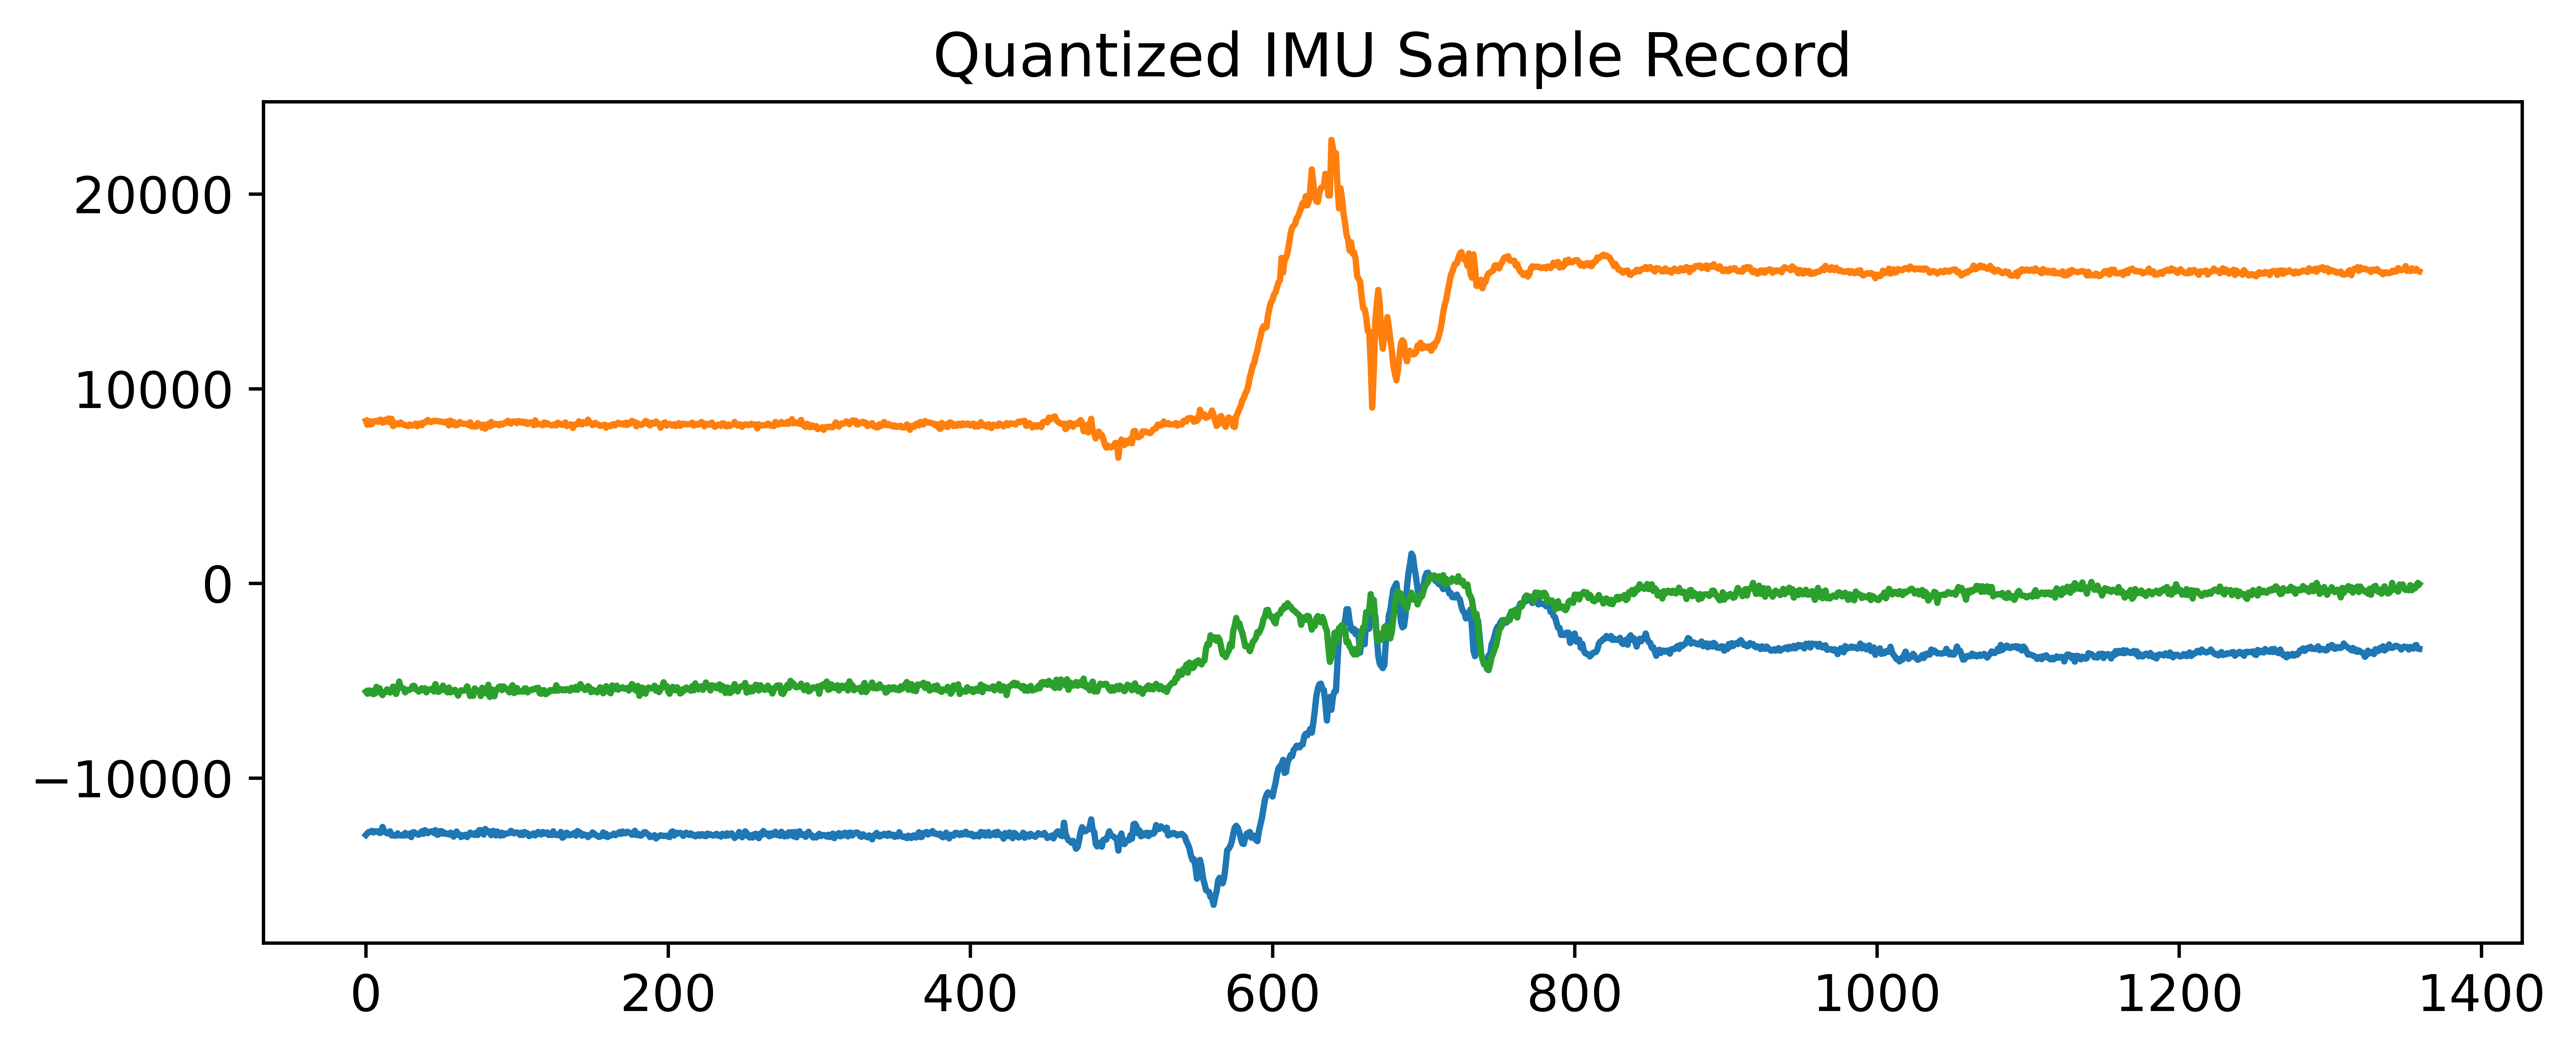

In [5]:
## Load and quantize an IMU sample record
with open("data.npy", "rb") as f:
    data = np.load(f)
    
quantizer = Quantizer(scale=0.49, num_bits=16)

data_quantized, _, _ = quantizer(data)
data_quantized.shape

plt.figure()
plt.plot(data_quantized[0])
plt.title(f"Quantized IMU Sample Record")
plt.show()


## Using the high-level simulation interface

In [6]:
# - Generate an IMU IF simulation with default parameters
mod_IMUIF = IMUIFSim()
print(mod_IMUIF)

IMUIFSim  with shape (3, 15) {
    ModSequential 'model' with shape (3, 15) {
        RotationRemoval '0_RotationRemoval' with shape (3, 3) {
            ModSequential 'sub_estimate' with shape (3, 9) {
                SubSpace '0_SubSpace' with shape (3, 9)
                SampleAndHold '1_SampleAndHold' with shape (9, 9)
            }
        }
        FilterBank '1_FilterBank' with shape (3, 15)
        ScaleSpikeEncoder '2_ScaleSpikeEncoder' with shape (15, 15)
    }
}

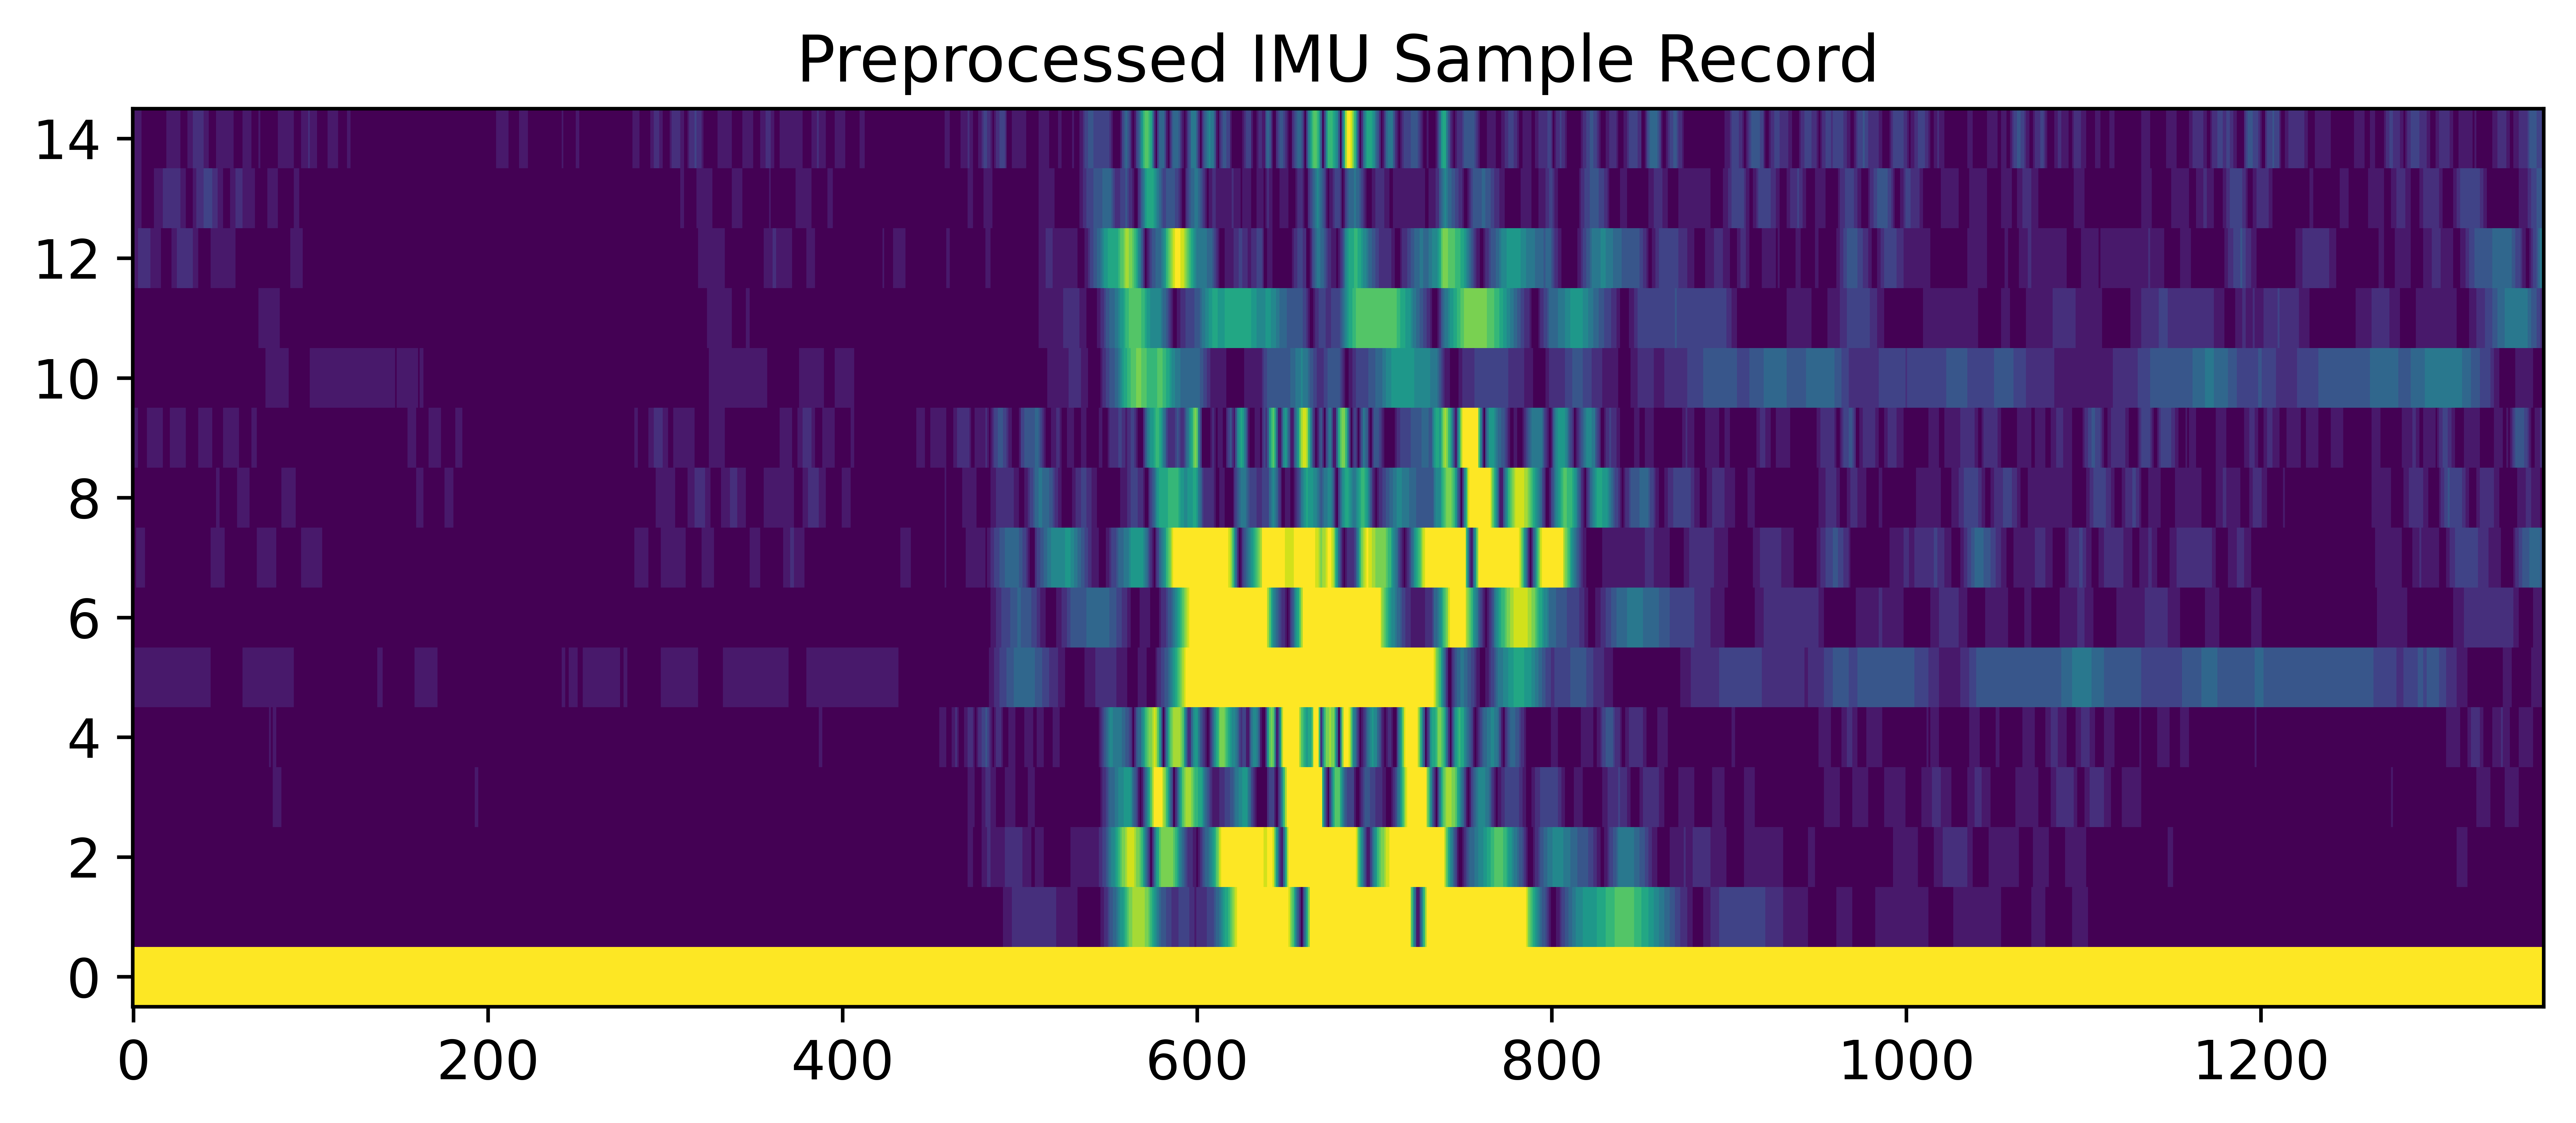

In [7]:
# - Pass an IMU sample through the simulation
result, _, _ = mod_IMUIF(data_quantized)

# - Display the encoded result
plt.figure()
plt.imshow(result[0].astype('float').T, aspect='auto', origin='lower')
plt.title(f"Preprocessed IMU Sample Record")
plt.show()

In [8]:
config = mod_IMUIF.export_config()
print(config)

xyloImu::configuration::InputInterfaceConfig(enable=1, configuration_timeout=3.000000, estimator_k_setting=4, 
select_iaf_output=0, bypass_jsvd=0, update_matrix_threshold=10, delay_threshold=500, bpf_bb_values={ 6 6 5 5 4 6 6 
5 5 4 6 6 5 5 4 }, bpf_bwf_values={ 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 }, bpf_baf_values={ 9 9 10 10 11 9 9 10 10 11 9 9
10 10 11 }, bpf_a1_values={ -64522 -64458 -63288 -62787 -59837 -64522 -64458 -63288 -62787 -59837 -64522 -64458 
-63288 -62787 -59837 }, bpf_a2_values={ 31754 31754 30771 30771 28888 31754 31754 30771 30771 28888 31754 31754 
30771 30771 28888 }, scale_values={ 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 }, iaf_threshold_values={ 1024 1024 1024 1024 
1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 1024 })

In [9]:
mod = IMUIFSim.from_config(config)
print(mod)

IMUIFSim  with shape (3, 15) {
    ModSequential 'model' with shape (3, 15) {
        RotationRemoval '0_RotationRemoval' with shape (3, 3) {
            ModSequential 'sub_estimate' with shape (3, 9) {
                SubSpace '0_SubSpace' with shape (3, 9)
                SampleAndHold '1_SampleAndHold' with shape (9, 9)
            }
        }
        FilterBank '1_FilterBank' with shape (3, 15)
        ScaleSpikeEncoder '2_ScaleSpikeEncoder' with shape (15, 15)
    }
}

## Next steps